In [ ]:
# default_exp timeseries.learner

# learner

> API details.

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.tabular.data import *
from fastai.tabular.core import *
from fastai.tabular.model import *
from fastai.basics import *
from fastrenewables.tabular.core import *
from fastrenewables.tabular.model import *
from fastrenewables.timeseries.core import *
from fastrenewables.timeseries.data import *
from fastrenewables.timeseries.model import *
from fastrenewables.losses import VILoss


In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
class RenewableTimeseriesLearner(Learner):
    "`Learner` for renewable data"
    def predict(self, ds_idx=1, test_dl=None, filter=True):
        device = next(self.model.parameters()).device
        preds, targets = None, None
        if test_dl is not None:
            to = test_dl.train_ds
        elif ds_idx == 0:
            to = self.dls.train_ds
        elif ds_idx == 1:
            to = self.dls.valid_ds
            
        # to increase speed we direclty predict on all tensors   
#         print(to)
        if isinstance(to, (TimeseriesDataset)):
            with torch.no_grad():
                preds = self.model(to.cats.to(device), to.conts.to(device))

            preds, targets = to_np(preds).reshape(-1), to_np(to.ys).reshape(-1)
            if filter:
                preds[preds < 0] = 0
                preds[preds > 1.1] = 1.1
        else:
            raise NotImplementedError("Unknown type")
            
        return preds, targets

In [ ]:
show_doc(RenewableTimeseriesLearner, title_level=3)

<h3 id="RenewableTimeseriesLearner" class="doc_header"><code>class</code> <code>RenewableTimeseriesLearner</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>RenewableTimeseriesLearner</code>(**`dls`**, **`model`**, **`loss_func`**=*`None`*, **`opt_func`**=*`Adam`*, **`lr`**=*`0.001`*, **`splitter`**=*`trainable_params`*, **`cbs`**=*`None`*, **`metrics`**=*`None`*, **`path`**=*`None`*, **`model_dir`**=*`'models'`*, **`wd`**=*`None`*, **`wd_bn_bias`**=*`False`*, **`train_bn`**=*`True`*, **`moms`**=*`(0.95, 0.85, 0.95)`*) :: `Learner`

`Learner` for renewable data

In [ ]:
def get_dls():
    cat_names = ['TaskID', 'Month', 'Day', 'Hour']
    pd.options.mode.chained_assignment=None
    cont_names = ['T_HAG_2_M', 'RELHUM_HAG_2_M', 'PS_SFC_0_M', 'ASWDIFDS_SFC_0_M',
           'ASWDIRS_SFC_0_M', 'WindSpeed58m']
    pd.options.mode.chained_assignment=None
    dls = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5"), y_names="PowerGeneration", 
                                      pre_procs=[FilterYear(year=2020), 
                                                 AddSeasonalFeatures(as_cont=False),
                                                FilterInconsistentSamplesPerDay], 
                                      cat_names=cat_names, cont_names=cont_names, bs=13, procs=Categorify)
    return dls



In [ ]:
dls = get_dls()

is cont


In [ ]:
#export
@delegates(Learner.__init__)
def renewable_timeseries_learner(dls, layers=None, emb_szs=None, config=None, 
                                 n_out=None, y_range=None, 
                                 embedding_type=EmbeddingType.Normal, **kwargs):
    "Get a `Learner` using `dls`, with `metrics`, including a `TabularModel` created using the remaining params."
    if config is None: config = tabular_config()
    
#     if n_out is None: n_out = get_c(dls)
    n_out = dls.train_ds.ys.shape[1]
        
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    
    if layers is None: layers = [len(dls.cont_names), 200, 100, n_out]
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
        
    embed_p = kwargs["embed_p"].pop() if "embed_p" in kwargs.keys() else 0.1
    
    emb_module = None
    if len(dls.train_ds.cat_names) > 0:
        emb_szs = get_emb_sz(dls.train_ds, {} if emb_szs is None else emb_szs)
        emb_module = EmbeddingModule(None, embedding_dropout=embed_p, embedding_dimensions=emb_szs)
        
    model = TemporalCNN(layers, embedding_module=emb_module, **config)
    
    if embedding_type==EmbeddingType.Bayes and "loss_func" not in kwargs.keys():
        base_loss = getattr(dls.train_ds, 'loss_func', None)
        assert base_loss is not None, "Could not infer loss function from the data, please pass a loss function."
        loss_func=VILoss(model=model, base_loss=base_loss, kl_weight=0.1)
        kwargs["loss_func"] = loss_func
    
    return RenewableTimeseriesLearner(dls, model, **kwargs)

In [ ]:
#export
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.tabular.data import *
from fastai.tabular.core import *
from fastai.tabular.model import *
from fastai.basics import *
from fastrenewables.tabular.core import *
from fastrenewables.tabular.data import *
from fastrenewables.tabular.model import *
from fastrenewables.losses import VILoss

In [ ]:
learner = renewable_timeseries_learner(dls, loss_func=mse, metrics=rmse)

In [ ]:
learner.model

TemporalCNN(
  (embedding_module): EmbeddingModule(
    (embeddings): ModuleList(
      (0): Embedding(4, 3)
      (1): Embedding(13, 7)
      (2): Embedding(32, 11)
      (3): Embedding(25, 10)
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
  )
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): TemporalConvNet(
    (temporal_blocks): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(6, 200, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (act_func1): ReLU()
        (dropout1): Dropout2d(p=0.0, inplace=False)
        (conv2): Conv1d(200, 200, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (act_func2): ReLU()
        (dropout2): Dropout2d(p=0.0, inplace=False)
        (net): Sequential(
          (0): Conv1d(6, 200, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout2d(p=0.0, inplace=False)

In [ ]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,_rmse,time
0,0.053025,0.023182,0.152256,00:01
1,0.029050,0.020778,0.144145,00:01
2,0.021671,0.018095,0.134519,00:01
3,0.017826,0.017440,0.132060,00:01
4,0.015229,0.017197,0.131136,00:01


In [ ]:
preds, targets = learner.predict(1)

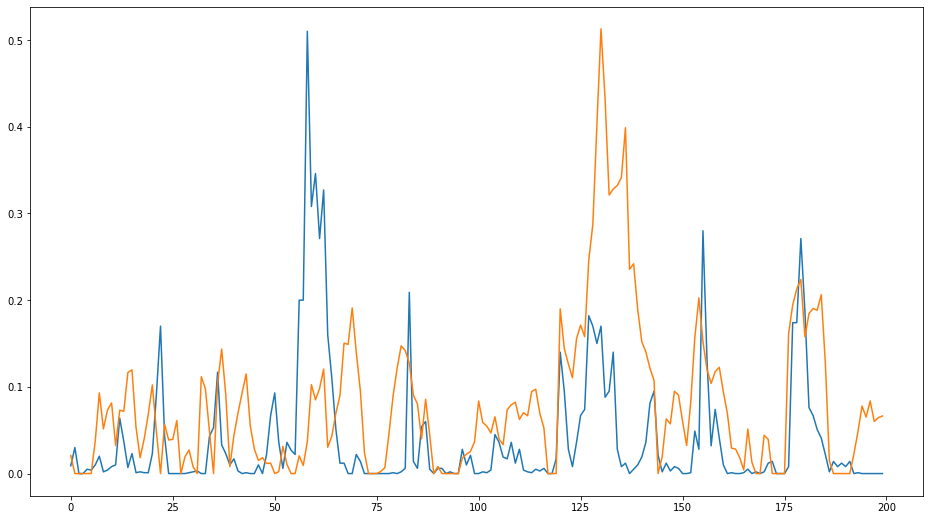

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(targets[0:200])
plt.plot(preds[0:200])